In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import scipy.io as sio
import os, os.path
import sys
import tensorflow as tf
sys.path.append('../')
import re
from datasets.dataset_utils import int64_feature, float_feature, bytes_feature ,ImageCoder, norm
from datasets import sythtextprovider
from processing import txt_preprocessing
import matplotlib.pyplot as plt
from PIL import Image
slim = tf.contrib.slim
import cv2


In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    #fig = plt.figure(figsize=(10,10))
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255),)
    #print [ymin,xmin,ymax,xmax]
    plt.imshow(image)
    plt.show()

In [ ]:
## test the tf record
batch_size = 1
num_readers = 4
shuffe = False
with tf.Graph().as_default():
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern = '*.tfrecord')

    provider = slim.dataset_data_provider.DatasetDataProvider(
                dataset,
                num_readers=num_readers,
                common_queue_capacity=20 * batch_size,
                common_queue_min=10 * batch_size,
                shuffle=shuffe)

    [image, shape, glabels, gbboxes, corx, cory] = provider.get(['image', 'shape',
                                                     'object/label',
                                                     'object/bbox',
                                                     'object/corx',
                                                     'object/cory'])
    shape = tf.cast(shape, tf.float32)
    cord = tf.concat([tf.expand_dims(tf.transpose(corx*shape[1]),0),tf.expand_dims(tf.transpose(cory*shape[0]),0)],0)
    with tf.Session() as sess,slim.queues.QueueRunners(sess): 
        sess.run(tf.global_variables_initializer())
        #with slim.queues.QueueRunners(sess):
        for i in xrange(1):
            image_, shape_, labels_ , gbboxes_ , corx_, cory_, cord_= \
                                    sess.run([image, shape, glabels, gbboxes, corx, cory,cord])
            chars = np.concatenate([np.expand_dims(corx_.T*shape_[1],0), np.expand_dims(cory_.T*shape_[0],0)], axis=0)
            chars = cord_
            fig = plt.figure(figsize=(10,10))
            for i in range(chars.shape[2]):
                cv2.polylines(image_,np.array(np.expand_dims(chars[:,:,i].T,axis=0),dtype=np.int32),True ,(0,255,255))
            plt.imshow(image_)
            plt.show() 
            visualize_bbox(image_, gbboxes_)

In [ ]:
gbboxes_.shape

file_path: ../data/sythtext/*.tfrecord


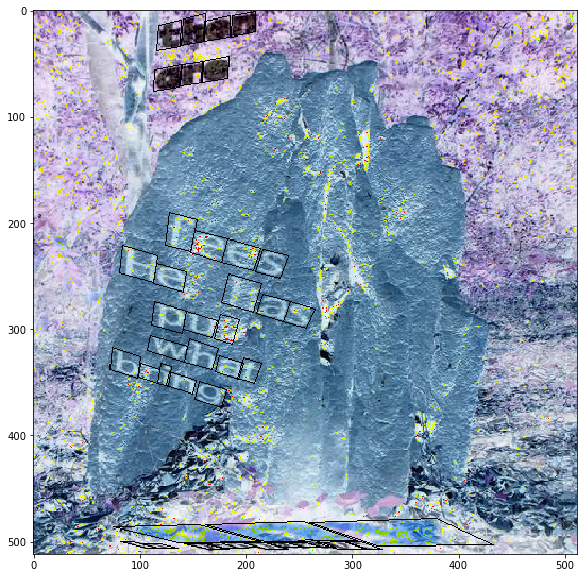

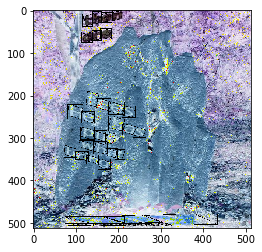

In [18]:
batch_size = 1
num_readers = 4
shuffe = True
with tf.Graph().as_default():
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern = '*.tfrecord')

    provider = slim.dataset_data_provider.DatasetDataProvider(
                dataset,
                num_readers=num_readers,
                common_queue_capacity=20 * batch_size,
                common_queue_min=10 * batch_size,
                shuffle=shuffe)

    [image, shape, glabels, gbboxes, corx, cory] = provider.get(['image', 'shape',
                                                     'object/label',
                                                     'object/bbox',
                                                     'object/corx',
                                                     'object/cory'])
    corx = tf.expand_dims(corx,-1)
    cory = tf.expand_dims(cory,-1)

    cord = tf.concat([corx, cory],-1)
    image, glabels, gbboxes, gcord, num = \
    txt_preprocessing.preprocess_image(image, glabels,gbboxes, cord,
                                       out_shape = (512,512),is_training=True)
    bbox_ref = tf.constant([1.,2.,3.,4.],dtype=tf.float32)
    vx = tf.expand_dims([bbox_ref[1], bbox_ref[1], bbox_ref[1], bbox_ref[1]],1)
    vy = tf.expand_dims([bbox_ref[0], bbox_ref[0], bbox_ref[0], bbox_ref[0]],1)
    v = tf.concat([vx,vy],-1)
    test = cord - v
    sx = tf.expand_dims([bbox_ref[2] - bbox_ref[0],
                    bbox_ref[2] - bbox_ref[0],
                    bbox_ref[2] - bbox_ref[0],
                    bbox_ref[2] - bbox_ref[0]], 1)
    sy = tf.expand_dims([bbox_ref[3] - bbox_ref[1],
                        bbox_ref[3] - bbox_ref[1],
                        bbox_ref[3] - bbox_ref[1],
                        bbox_ref[3] - bbox_ref[1]], 1)
    s = tf.concat([sx,sy],-1)
    test = cord / s
    with tf.Session() as sess,slim.queues.QueueRunners(sess): 
        sess.run(tf.global_variables_initializer())
        #with slim.queues.QueueRunners(sess):
        for i in xrange(1):
            image_, shape_, labels_ , gbboxes_ , corx_, cory_, cord_, test_= \
                                    sess.run([image, shape, glabels, gbboxes, corx, cory,gcord, test])
            corx_ = np.transpose(np.expand_dims(cord_[:,:,0],-1), (2,1,0))
            cory_ = np.transpose(np.expand_dims(cord_[:,:,1],-1), (2,1,0))
            chars = np.concatenate([corx_*512, cory_*512], 0)
            
            fig = plt.figure(figsize=(10,10))
            for i in range(chars.shape[2]):
                cv2.polylines(image_,np.array(np.expand_dims(chars[:,:,i].T,axis=0),dtype=np.int32),True ,(255))
            plt.imshow(image_)
            plt.show() 
            visualize_bbox(image_, gbboxes_)

In [ ]:
print labels_.shape
print gbboxes_.shape
test_.shape

In [ ]:
with tf.Graph().as_default():
    bbox_ref = tf.constant([1,2,3,4])
    vx = tf.expand_dims([bbox_ref[1], bbox_ref[1], bbox_ref[1], bbox_ref[1]],1)
    vy = tf.expand_dims([bbox_ref[0], bbox_ref[0], bbox_ref[0], bbox_ref[0]],1)
    v = tf.concat([vx,vy],-1)
    cord - v